## PID

### 連続時間
$$
\begin{aligned}
e(t) &= r(t) - y(t)\\
u(t) &= \underbrace{\vphantom{\int} K_pe(t)}_{比例P} + \underbrace{K_i\int_0^t e(\tau)d\tau}_{積分I} + \underbrace{\vphantom{\int} K_d\dot{e}(t)}_{微分D} \\
y(t) &= \int_0^t u(t) d\tau \\
\end{aligned}
$$

### 離散時間
$$
\begin{aligned}
e_{k} &= r_{k} - y_{k-1} \\
u_{k} &= K_p e_{k} + K_i \sum_0^n e_{n} + K_d \frac{ e_{k} - e_{k-1} }{dt} \\
y_{k} &= y_{k-1} + u_{k} dt \\
\end{aligned}
$$

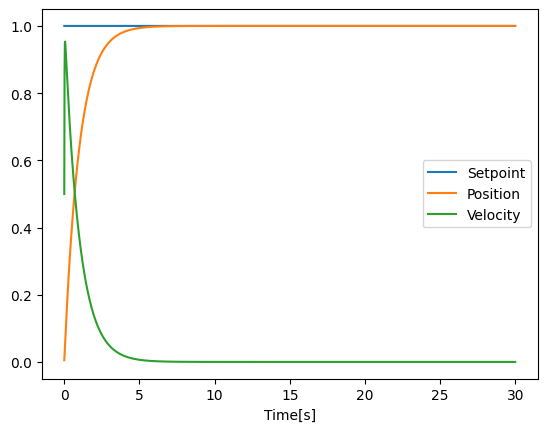

In [111]:
import matplotlib.pyplot as plt
import numpy as np

# モデル設定
tau = 0.5 # 時定数
dt = 10e-3 # 制御周期(100Hz = 10ms)
t = np.arange(0, 30, dt) # 時間(グラフの横軸) 0~10まで
setpoint = np.full_like(t, 1) # 目標値

# PIDゲイン
kp = 100
ki = 0
kd = 0

# シミュレーション
position = np.zeros_like(t) # 状態出力
velocity = np.zeros_like(t) # 状態出力
control = np.zeros_like(t) # 制御出力
error = np.zeros_like(t)
integral = np.zeros_like(t)

for i in range(len(t)):
  error[i] = setpoint[i] - position[i-1]
  integral[i] = integral[i-1] + error[i] * dt
  derivative = (error[i] - error[i-1]) / dt if i > 0 else 0
  control[i] = kp * error[i] + ki * integral[i] + kd * derivative
  velocity[i] = tau * velocity[i-1] + (1 - tau) * control[i] * dt
  position[i] = position[i-1] + velocity[i] * dt

plt.plot(t, setpoint, label='Setpoint')
plt.plot(t, position, label='Position')
plt.plot(t, velocity, label='Velocity')
# plt.plot(t, control, label='Control Output')
# plt.plot(t, integral, label='Integral')
# plt.plot(t, error, label='Error')

plt.xlabel('Time[s]')
plt.legend()
plt.show()
